<a href="https://colab.research.google.com/github/park-jaehun/XAI/blob/main/%EC%A0%84%EA%B8%B0%EC%B0%A8%EA%B5%AC%EB%A7%A4%EC%98%88%EC%B8%A1(shap%2B%EB%B6%84%EC%82%B0%EB%B6%84%EC%84%9D_%EC%A4%91%EC%8B%AC%EC%9C%BC%EB%A1%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 그래프 한글 패치 설치 및 설정
# -런타임 유형 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
#2024.12.24
#  전기차 가격 예측
#0. 사용할 패키지 불러오기
import pandas as pd
import numpy as np

import seaborn as sns


In [3]:
ev_data = pd.read_csv('/content/drive/MyDrive/전기차 가격 예측(연습)/open (1)/train.csv')
ev_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [5]:
# 결측치 값 확인해보기
print("count of missing values:\n",ev_data.shape[0]-ev_data.count())
ev_data["배터리용량"]=ev_data["배터리용량"].fillna(0)

# 수치형 변수 필터링
float_data=ev_data.select_dtypes(include=['float64','int64'])

count of missing values:
 ID          0
제조사         0
모델          0
차량상태        0
배터리용량       0
구동방식        0
주행거리(km)    0
보증기간(년)     0
사고이력        0
연식(년)       0
가격(백만원)     0
dtype: int64


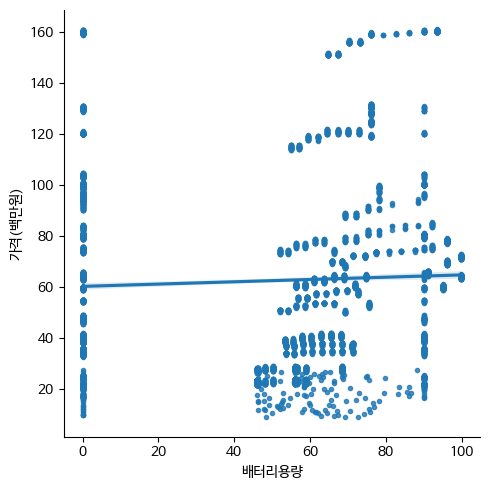

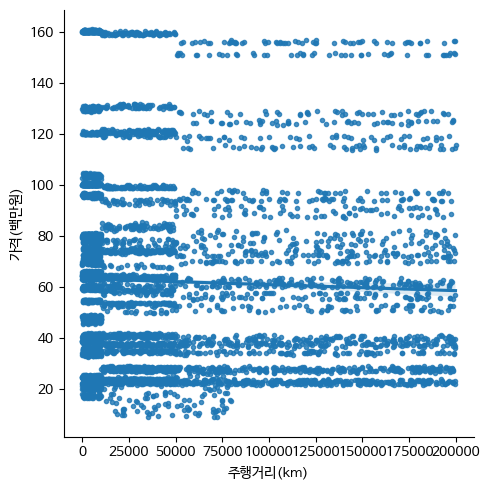

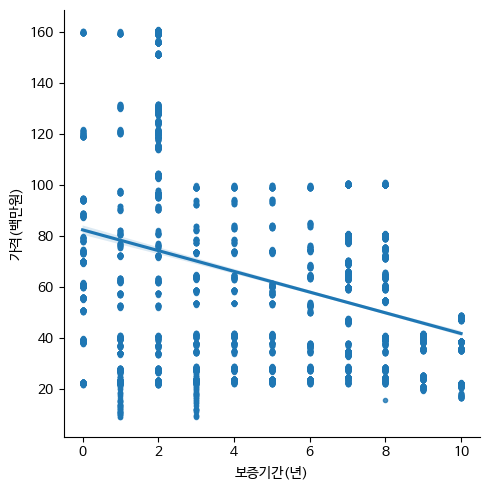

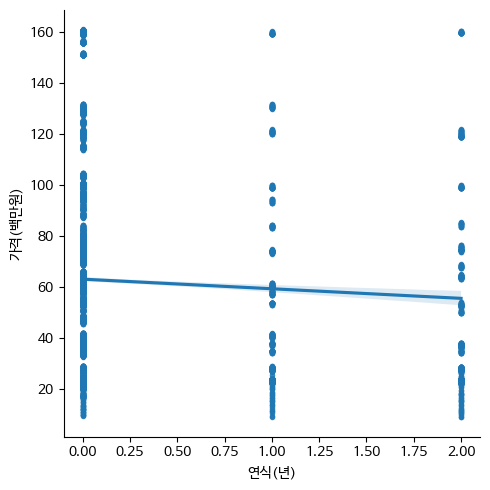

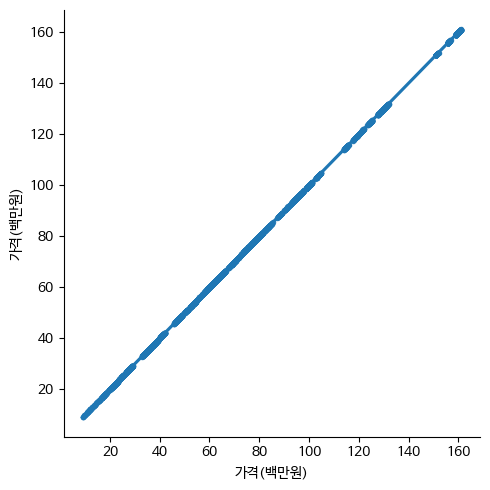

In [6]:
#3-9 다른 input 변수들로 output간의 관계에 있어서 선형인지 확인하기
col = float_data.columns.tolist()[:]
for i in float_data.columns.tolist()[:]:
    sns.lmplot(x=i, y="가격(백만원)", data=float_data, markers=".")

독립변수와 종속변수간의 선형성을 살펴본 결과 --- 없음

In [9]:
df_encoded = ev_data.copy()

for column in ev_data.select_dtypes('object'):
    df_encoded[column] = LabelEncoder().fit_transform(df_encoded[column])

y = ev_data['가격(백만원)']
X = df_encoded.drop(columns='가격(백만원)',axis=1)



랜덤포레스트 모델로 예측하기

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [12]:

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 모델 평가 (MSE 사용)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2.146565681466668


In [13]:
import shap
explainer = shap.TreeExplainer(rf_model.fit(X_train, y_train))
shap_values = explainer(X_test)

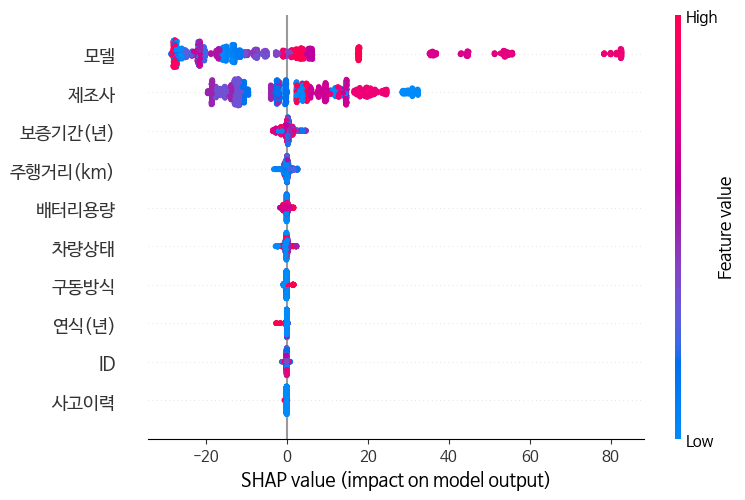

In [14]:
shap.plots.beeswarm(shap_values)

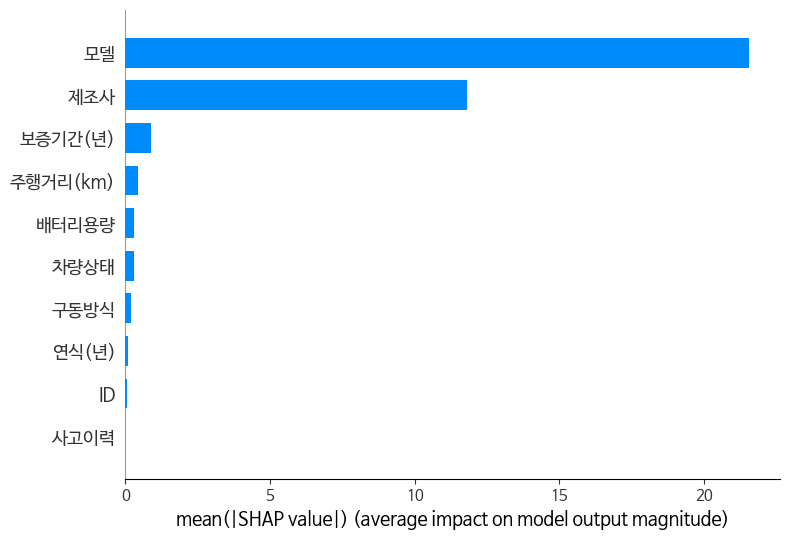

In [15]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [36]:

# 그냥 확인하기에 피쳐종류가 30개나 되어 한눈에 들어오지 않는다.
print(rf_model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# 내림차순 정렬을 이용한다
top_feature = ser.sort_values(ascending = False)

[5.14754593e-04 3.47201756e-01 6.36564715e-01 2.18840627e-03
 3.52884897e-03 1.27156458e-03 3.41441582e-03 5.07810214e-03
 1.46605783e-05 2.22776478e-04] 



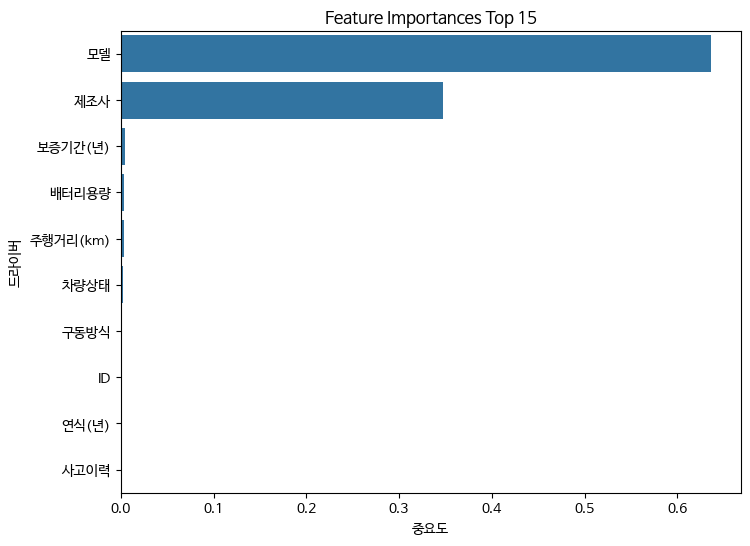

In [41]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top_feature, y=top_feature.index)
plt.xlabel("중요도")
plt.ylabel("드라이버")

plt.show()



/usr/local/lib/python3.10/dist-packages/shap/plots/_waterfall.py:237: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


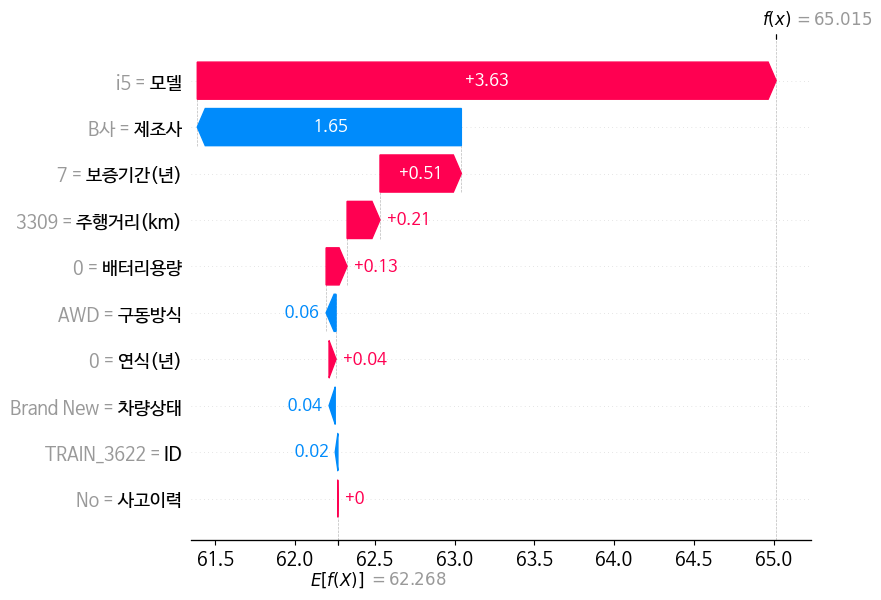

In [74]:
idx = 20
want_to_show = shap_values[idx]
want_to_show.data = ev_data.drop(columns='가격(백만원)').loc[X_test.iloc[idx].name].to_numpy()
shap.plots.waterfall(want_to_show)

상위 5개 피처를 바탕으로 포트폴리오 비중 살펴보기
- 모델 ev6
- 제조사_p사
- 제조사_T사
- 제조사_A사

# 포토폴리오 비중 확인하기

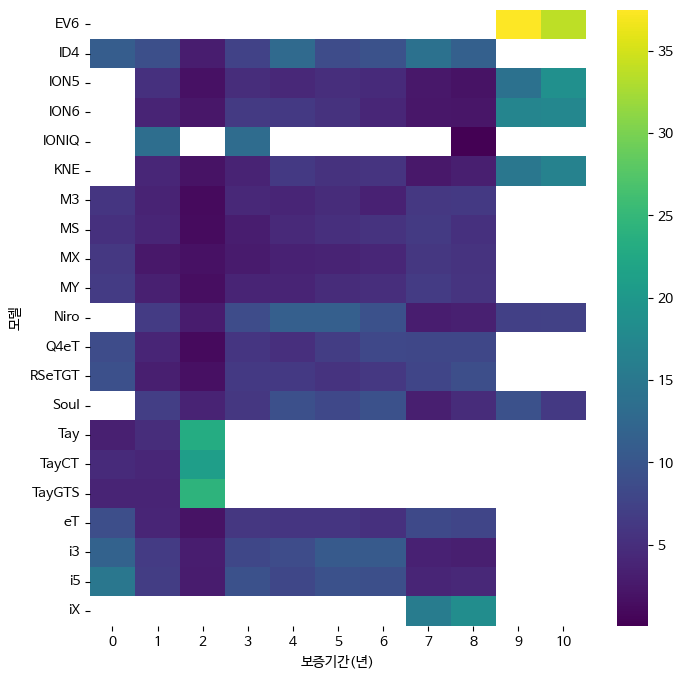

In [45]:
# @title 제조사 vs 차량상태

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({ x_label: round((grp['모델'].value_counts())/(grp['모델'].value_counts().sum())*100,2) for x_label, grp in ev_data.groupby('보증기간(년)') })
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('보증기간(년)')
_ = plt.ylabel('모델')